# Context

## Understanding the data
### Source
As stated in the [Data Set Description](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection#), this is a compiled dataset from a few sources:
* 425 SMS spam messages from Grumbletext Web site - **UK Forum**
* 3,375 SMS ham messages of the NUS SMS Corpus - **Singapore**
* 450 SMS ham messages collected from Caroline Tag's PhD Thesis - **UK Thesis**
* 1,002 SMS ham messages, 322 spam message from SMS Spam Corpus v.0.1 Big - **UK**

I find this a bit odd, because if we have any *correct* predictors to Singapore then its 100% sure to be spam. Further, thats well over half our spam. This makes our classification task a little less realistic than what we might encounter for commercial purposes.

### Digging In
This data is quite 'messy'. Given that this is spam classification over other tasks like say topic classification, we need to adjust our approach accordingly. When we see odd punctuation, misspelled words, erratic patterns, odd capitializations, these are usually features and not noise, so the 'messy-ness' is actually helpful, and we need a tokenizer that will handle these accordingly. Further, I will *not* be filtering any stop words.

We also have a dataset of size 5572, we **might** struggle with overfitting the data if we immediately jump into Deep Learning. Because of this, I will spend my time on more traditional methods, but I will look into it if I have time.

## Goal
The [paper](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/doceng11.pdf) that comes with the dataset, boasts 

| Classifier          | SC%    | BH%  | Acc%   | MCC   |
|---------------------|--------|------|--------|-------|
| SVM + tok1          | 83.10  | 0.18 | 97.64  | 0.893 |
| Boosted NB + tok2   | 84.48  | 0.53 | 97.50  | 0.887 |
| Boosted C4.5 + tok2 | 82.91  | 0.29 | 97.50  | 0.887 |

And naturally we want to do better than 3 top notch researchers from 2011, so our goal is to beat the MCC score of .893.

## Data Status
By the time the data gets to this notebook, it has:
* Been downloaded, and unzipped
* Read into a pandas dataframe

# Pre-processing
There are a few factors at play here and we want to optimize each step.


In [1]:
% matplotlib inline
import pandas as pd
from pathlib import Path
import sys
import seaborn as sns
from matplotlib import pyplot as plt
import re
from pprint import pprint
from itertools import zip_longest
import numpy as np

plt.style.use('ggplot')

# Adding src dir to path for imports
project_dir = Path.cwd().parent
sys.path.append(str(project_dir/'src'))

# These are utilities that I created to reduce notebook clutter
from make_dataframe import make_dataframe, master_data_handler
import utilities as ut

## Data Acquisition
First we get our data, and then we encode it for use with our Classifiers. We should note our mapping for later on.

In [2]:
master_data_handler()
df = make_dataframe()
df.label = df.label.map({'ham': 0, 'spam': 1})
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Its interesting to note our imbalanced dataset. With no machine learning we can get 86.6% Accuracy! This is a good warning that accuracy will probably not be a good metric for us. Depending on our classifier we need to handle this accordingly. 

SVM has a [class_weight parameter](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py) that allows us to compensate.

Naive Bayes has a [complement class](http://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf) structure that allows us to compensate. It has a corresponding function in sklearn - [ComplementNB](http://scikit-learn.org/dev/modules/generated/sklearn.naive_bayes.ComplementNB.html). Unfortunately this is for version 0.20 which is in development. So we will have to make due with Multinomial Naive Bayes instead.

In [3]:
ratio = sum(df.label == 0)/len(df.label)
print('Percentage of ham in total labels: ', ratio)

Percentage of ham in total labels:  0.8659368269921034


## Tokenization
As said before, we need to choose a tokenizer that will capture the features we want: 

* Punctuation preservation
* Case preservation
* Full words in tokens

There is research in spam classification [section 3.2](http://www.siefkes.net/ie/winnow-spam.pdf) with some good options. Unfortunately these are all in PCRE regex which python does not support fully (`\p{Z}` among other atoms). But luckily they aren't too hard to convert, given our dataset (minimal control characters). 

I chose the simplified CRM114. Look how it handles an elipsis, we capture an extra feature of `'..'`!

*Note: Null means no tokens were captured. Blank spaces are whitespace characters.*

In [4]:
fmt = '%-8s%-20s%s'

print(fmt % ('', 'SCRM114', 'Eager Token'))
for i, (scrm, ets) in enumerate(zip_longest(ut.scrm114_tokenizer(df.text[0]), ut.eager_split_tokenizer(df.text[0]), fillvalue='NULL')):
    print(fmt % (i, scrm, ets))

        SCRM114             Eager Token
0       Go                  Go
1       until               until
2       jurong              jurong
3       point,              point
4       crazy.              
5       .                   crazy
6       Available           
7       only                
8       in                  Available
9       bugis               only
10      n                   in
11      great               bugis
12      world               n
13      la                  great
14      e                   world
15      buffet.             la
16      ..                  e
17      Cine                buffet
18      there               
19      got                 
20      amore               
21      wat.                Cine
22      ..                  there
23      NULL                got
24      NULL                amore
25      NULL                wat
26      NULL                
27      NULL                
28      NULL                


# Modeling

## Classification Comparison Metric
As suggested in the dataset paper, Matthews Correlation Coefficient has been [researched](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5456046/) to be a metric that is good for unbalanced data.

## Hyperparameter Optimization
There are many ways to determine the fit of a model to the data, and one of the most important is how we tune our hyperparameters (HPs). There are many options, and we need to be smart in how we choose our HPs. We will use a grid search optimized with 3-fold cross validation. This will test HPs against partitioned training data 3 times.

## Pipeline
Training a model takes multiple sequential steps. A [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to keep the code for these steps clean.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer, f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.2, random_state=0)
data_args = [X_train, y_train, X_test, y_test]

# Training

## SVM
Optimal linear kernal training [reference](https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/).

In [7]:
pipeline_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LinearSVC(class_weight={0: .09})),
])

parameters_svm = {
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'vect__max_df': (.01, .03, .1),
    'vect__tokenizer': [ut.scrm114_tokenizer, ut.eager_split_tokenizer],
}

model_svm = ut.grid_search_analysis(pipeline_svm, parameters_svm, *data_args)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best score:  0.9268453402159025
Best params:  {'vect__max_df': 0.1, 'vect__ngram_range': (1, 1), 'vect__tokenizer': <function scrm114_tokenizer at 0x00000232C8ACF840>}
Confusion Matrix:
 [[953   2]
 [ 13 147]]
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99       955
       spam       0.99      0.92      0.95       160

avg / total       0.99      0.99      0.99      1115

Matthews Correlation Coefficient:  0.9444658320675249


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   24.8s finished


## Multinomial Naive Bayes
Multinomial Naive Bayes (MNB) is our second choice of N

In [8]:
pipeline_mnb = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

parameters_mnb = {
    'vect__tokenizer': [ut.scrm114_tokenizer, ut.eager_split_tokenizer],
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'vect__max_df': (.003, .01, .03),
}

model_mnb = ut.grid_search_analysis(pipeline_mnb, parameters_mnb, *data_args)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   18.0s finished


Best score:  0.9453399463629355
Best params:  {'vect__max_df': 0.01, 'vect__ngram_range': (1, 2), 'vect__tokenizer': <function eager_split_tokenizer at 0x00000232C8C48510>}
Confusion Matrix:
 [[951   4]
 [  9 151]]
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99       955
       spam       0.97      0.94      0.96       160

avg / total       0.99      0.99      0.99      1115

Matthews Correlation Coefficient:  0.9521062862046046


# Random Forests

In [9]:
pipeline_rfc = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier()),
])

parameters_rfc = {
    'vect__tokenizer': [ut.scrm114_tokenizer, ut.eager_split_tokenizer],
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'vect__max_df': (.01, .03, .1),
}

model_rfc = ut.grid_search_analysis(pipeline_rfc, parameters_rfc, *data_args)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   28.1s finished


Best score:  0.8330844673109501
Best params:  {'vect__max_df': 0.03, 'vect__ngram_range': (1, 1), 'vect__tokenizer': <function scrm114_tokenizer at 0x00000232C8ACF840>}
Confusion Matrix:
 [[955   0]
 [ 35 125]]
             precision    recall  f1-score   support

        ham       0.96      1.00      0.98       955
       spam       1.00      0.78      0.88       160

avg / total       0.97      0.97      0.97      1115

Matthews Correlation Coefficient:  0.8681186845731698


# Metrics by train_test_split
Now that we have some strong results we need to explore more of where we are. Why should we pick an 80-20 split? What rules of thumb apply? Does that change with our messy data?

These are difficult questions to answer. We can have idea, but given our training times are reasonable, its worthwhile to investigate these. Lets plot some chosen metrics based on 

In [10]:
pipeline_svm.set_params(**model_svm.best_params_)
pipeline_mnb.set_params(**model_mnb.best_params_)
pipeline_rfc.set_params(**model_rfc.best_params_);

## Setup
Here we will use a 

In [12]:
classifier_list = [pipeline_svm, pipeline_mnb, pipeline_rfc]
classifier_names = ['SVM', 'MultinomialNB', 'Random Forest']
training_set= np.linspace(.05, .95, 19)
mbts_args = {'X':df.text, 'y':df.label, 'classifier_list':classifier_list, 'training_set':training_set}
   
mcc_array = ut.metric_by_training_size(metric=matthews_corrcoef, **mbts_args) 
f1_array = ut.metric_by_training_size(metric=f1_score, **mbts_args) 
acc_array = ut.metric_by_training_size(metric=accuracy_score, **mbts_args) 
training_set *= 100

## Results
### Matthews Correlation Coefficient
Here we can see that even with the weak generalization power of a 15-85 split we are above the Dataset Paper. As expected from above, we can see that Multinomial Naive Bayes has done very well. Its consistently outperforming the SVM by a small margin, but we shouldn't read too much into this if our goal was to say, try to use this classifier on data from other countries or with other differences.

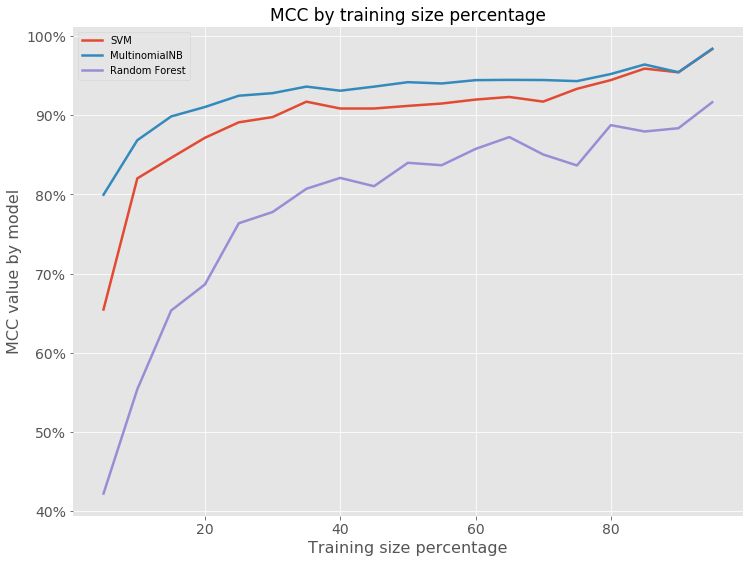

In [14]:
ut.plot_by_training_size(training_set, mcc_array, 'MCC', classifier_names)

## F1 Score
The [F1 score](https://en.wikipedia.org/wiki/F1_score) is another common metric. I wanted to see if our champ (MNB) would come out ahead again, and it did.  

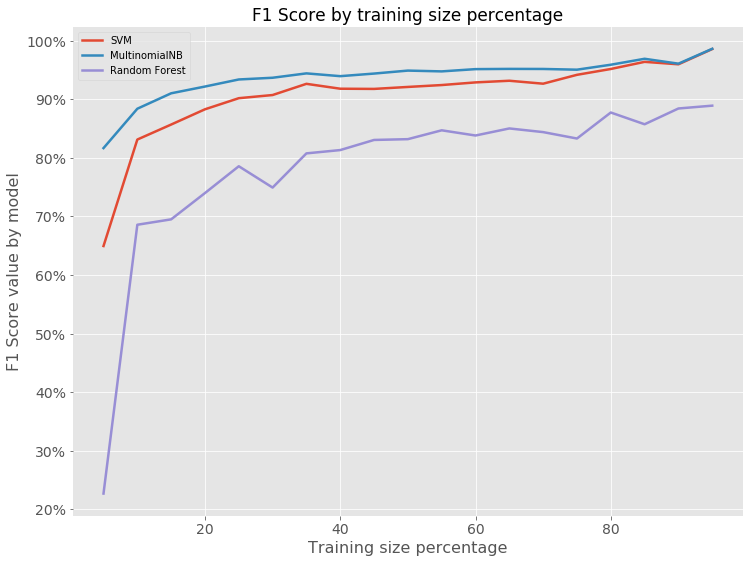

In [15]:
ut.plot_by_training_size(training_set, f1_array, 'F1 Score', classifier_names)

## Accuracy
Accuracy can be misleading due to the imbalanced dataset, but I was curious to see how well we did. Even with a 5-95 split SVM and MNB both exceeded blind guessing (86.6%) by a good margin which I find incredible. I suspect there are some really strong linear features. Some possibilities `£`, `buy`, or other strong spam tokens that the classifiers can discriminate on.

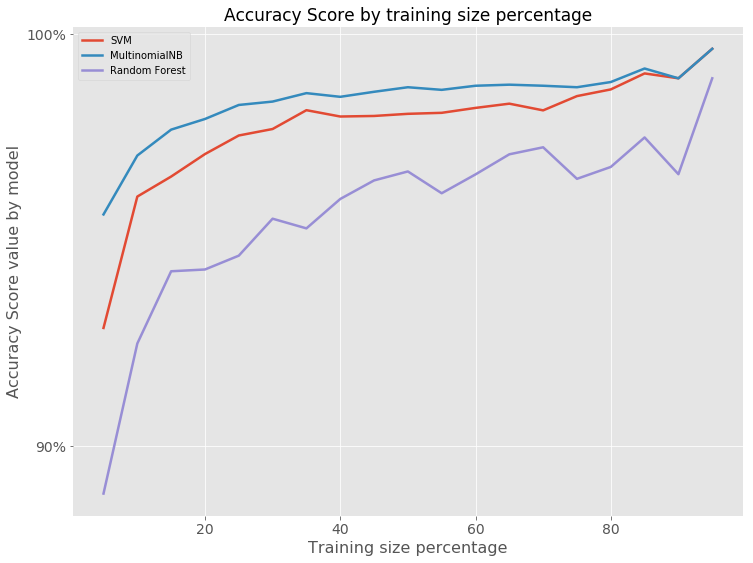

In [16]:
ut.plot_by_training_size(training_set, acc_array, 'Accuracy Score', classifier_names)